# 1st Part image colorisation

In [17]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,UpSampling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation, Dropout,BatchNormalization
from keras import optimizers
from keras import applications
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math 
import datetime
import time
import tensorflow as tf
from keras.optimizers import Adam
from tqdm import tqdm
from keras.preprocessing.image import img_to_array
from matplotlib.pyplot import imshow
import  cv2


In [3]:
from keras.layers import  UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import  load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import keras
import os

Using TensorFlow backend.


Transfer learning VGG16

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
from keras.applications.vgg16 import VGG16
new_model=VGG16(include_top=False,weights="imagenet")


In [11]:
new_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
for layer in new_model.layers:
    layer.trainable=False   

In [6]:
path = '/home/heroo/datascience/mg'

train_datagen = ImageDataGenerator(rescale=1. / 255)

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None)


Found 210 images belonging to 1 classes.


In [7]:
X =[]
Y =[]
for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0]) 
        Y.append(lab[:,:,1:] / 128) 
    except:
        print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

(32, 224, 224, 1)
(32, 224, 224, 2)


In [23]:
vggfeatures = []
for i, sample in enumerate(X):
    sample = gray2rgb(sample)
    sample = sample.reshape((1,224,224,3))
    prediction = new_model.predict(sample)
    prediction = prediction.reshape((7,7,512))
    vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)


(32, 7, 7, 512)


Decoder model

In [9]:
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 56, 56, 32)       

In [10]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=10, batch_size=128)

model.save('colorize_autoencoder_VGG16.model')


Epoch 1/10
32/32 [==============================] - 2s 66ms/step - loss: 0.3082 - accuracy: 0.5571
Epoch 2/10
32/32 [==============================] - 1s 19ms/step - loss: 0.7961 - accuracy: 0.7447
Epoch 3/10
32/32 [==============================] - 1s 20ms/step - loss: 0.6066 - accuracy: 0.7396
Epoch 4/10
32/32 [==============================] - 1s 19ms/step - loss: 0.8801 - accuracy: 0.6584
Epoch 5/10
32/32 [==============================] - 1s 19ms/step - loss: 0.5447 - accuracy: 0.7450
Epoch 6/10
32/32 [==============================] - 1s 20ms/step - loss: 0.6793 - accuracy: 0.7484
Epoch 7/10
32/32 [==============================] - 1s 20ms/step - loss: 0.5509 - accuracy: 0.7458
Epoch 8/10
32/32 [==============================] - 1s 19ms/step - loss: 0.2889 - accuracy: 0.7433
Epoch 9/10
32/32 [==============================] - 1s 19ms/step - loss: 0.1885 - accuracy: 0.7174
Epoch 10/10
32/32 [==============================] - 1s 20ms/step - loss: 0.1087 - accuracy: 0.6915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


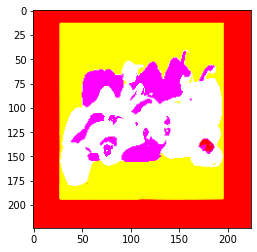

In [12]:
#model = tf.keras.models.load_model('colorize_autoencoder_VGG16_10000.model',custom_objects=None,compile=True)
#model=np.load('bottleneck_features_validation.npy')
testpath =  '/home/heroo/Downloads/family_pic/mg.png'

from skimage.color import rgb2gray
test = img_to_array(load_img(testpath))

test = resize(test, (224,224), anti_aliasing=True)
test*= 1.0/255
lab = rgb2lab(test)

imshow(lab)


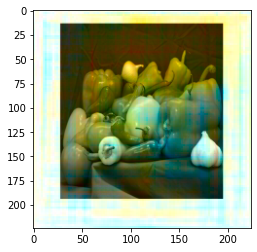

In [19]:
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
    #print(L.shape)
dn_Model=tf.keras.models.load_model('colorize_autoencoder_VGG16.model',custom_objects=None,compile=True)    
vggpred = new_model.predict(L)
ab = dn_Model.predict(vggpred)
    #print(ab.shape)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab
imshow(lab2rgb(cur))


# 2nd  part image denoising 

In [62]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

In [63]:
x_train.shape

(60000, 28, 28)

In [64]:
x_test.shape

(10000, 28, 28)

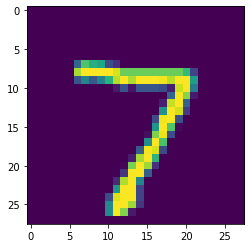

In [65]:
plt.imshow(x_test[0].reshape(28, 28))

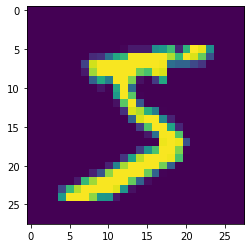

In [66]:
plt.imshow(x_train[0].reshape(28, 28))

In [67]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [68]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 


In [69]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

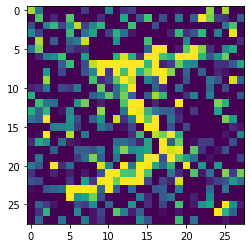

In [70]:
plt.imshow(x_train_noisy[0].reshape(28, 28))

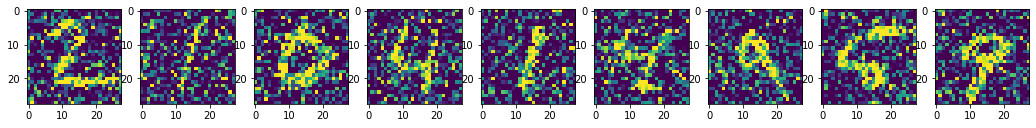

In [71]:
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
plt.show()

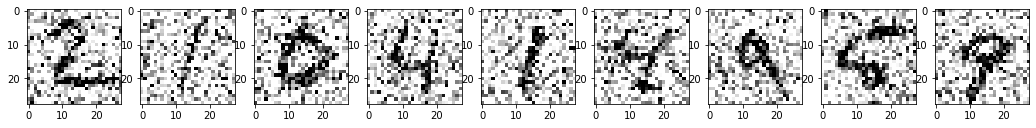

In [72]:
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
plt.show()

Encoder Part

In [73]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 

model.add(MaxPooling2D((2, 2), padding='same'))
 


Decoder Part

In [74]:
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))

In [75]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

model.fit(x_train_noisy, x_train, epochs=2, batch_size=256, shuffle=True, 
          validation_data=(x_test_noisy, x_test))



model.evaluate(x_test_noisy, x_test)

model.save('denoising_autoencoder.model')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 8)         2312      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 8)          

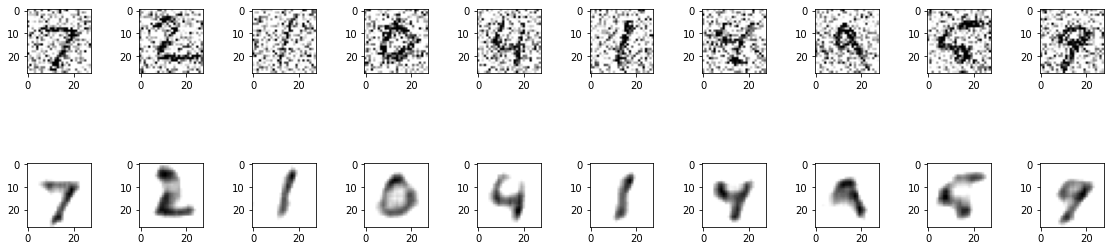

In [76]:
no_noise_img = model.predict(x_test_noisy)

plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
    
    # display reconstructed (after noise removed) image
    ax = plt.subplot(3, 20, 40 +i+ 1)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap="binary")

plt.show()

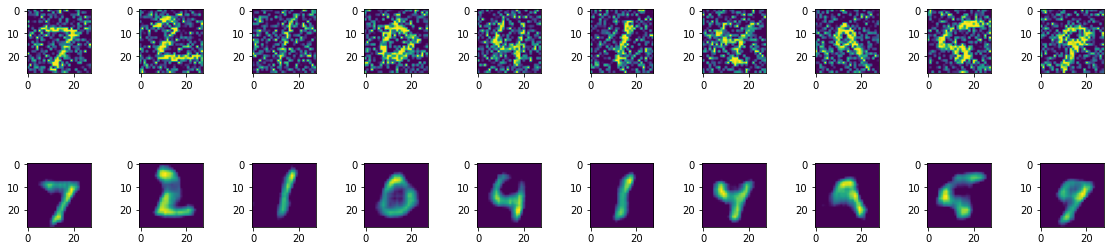

In [77]:
no_noise_img = model.predict(x_test_noisy)

plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    
    # display reconstructed (after noise removed) image
    ax = plt.subplot(3, 20, 40 +i+ 1)
    plt.imshow(no_noise_img[i].reshape(28, 28))

plt.show()

# 3rd Part Anomaly Detection

In [7]:
path='/home/heroo/datascience/spx.csv'

In [14]:
df=pd.read_csv(path,index_col="date" ,parse_dates=['date'])

In [15]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [19]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df, test_size=0.05,random_state=0)

In [26]:
train.shape[0]

7782

In [60]:
model=Sequential()
model.add(Dense(20,input_dim=train.shape[1],activation='relu'))
#model.add(Dense(32,activation='relu'))
#model.add(Dense(16,activation='relu'))
model.add(Dense(5,activation='relu'))

#model.add(Dense(2,activation='relu'))
model.add(Dense(20,activation='relu'))
#model.add(Dense(32,activation='relu'))
#model.add(Dense(64,activation='relu'))

model.add(Dense(train.shape[1]))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 20)                40        
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_35 (Dense)             (None, 20)                120       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 21        
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(train,train,verbose=1,epochs=100)
pred=model.predict(test)

Epoch 1/100
7782/7782 [==============================] - 0s 44us/step - loss: 1520981.6819
Epoch 2/100
7782/7782 [==============================] - 0s 31us/step - loss: 1520460.9522
Epoch 3/100
7782/7782 [==============================] - 0s 32us/step - loss: 1519942.0267
Epoch 4/100
7782/7782 [==============================] - 0s 31us/step - loss: 1519422.5981
Epoch 5/100
7782/7782 [==============================] - 0s 31us/step - loss: 1518904.4700
Epoch 6/100
7782/7782 [==============================] - 0s 31us/step - loss: 1518386.6850
Epoch 7/100
7782/7782 [==============================] - 0s 31us/step - loss: 1517867.9634
Epoch 8/100
7782/7782 [==============================] - 0s 31us/step - loss: 1517349.6372
Epoch 9/100
7782/7782 [==============================] - 0s 31us/step - loss: 1516831.7497
Epoch 10/100
7782/7782 [==============================] - 0s 31us/step - loss: 1516313.2289
Epoch 11/100
7782/7782 [==============================] - 0s 31us/step - loss: 1515795.67

7782/7782 [==============================] - 0s 30us/step - loss: 1475284.8433
Epoch 91/100
7782/7782 [==============================] - 0s 30us/step - loss: 1474777.0473
Epoch 92/100
7782/7782 [==============================] - 0s 30us/step - loss: 1474269.5947
Epoch 93/100
7782/7782 [==============================] - 0s 29us/step - loss: 1473762.5006
Epoch 94/100
7782/7782 [==============================] - 0s 29us/step - loss: 1473254.9416
Epoch 95/100
7782/7782 [==============================] - 0s 29us/step - loss: 1472747.3264
Epoch 96/100
7782/7782 [==============================] - 0s 29us/step - loss: 1472239.9348
Epoch 97/100
7782/7782 [==============================] - 0s 29us/step - loss: 1471732.5407
Epoch 98/100
7782/7782 [==============================] - 0s 30us/step - loss: 1471224.9631
Epoch 99/100
7782/7782 [==============================] - 0s 30us/step - loss: 1470717.9157
Epoch 100/100
7782/7782 [==============================] - 0s 30us/step - loss: 1470210.6584


In [62]:
score1=np.sqrt(metrics.mean_squared_error(pred,test))
score1

1259.3034875456433

In [63]:
pred1=model.predict(train)
score2=np.sqrt(metrics.mean_squared_error(pred1,train))
score2

1212.4169613503825

In [64]:
path1='/home/heroo/datascience/Book2.csv'

In [65]:
bad=pd.read_csv(path,index_col="date" )
pred2=model.predict(bad)
score2=np.sqrt(metrics.mean_squared_error(pred2,bad))
score2

1214.8065961950708